In [1]:
import kagglehub

path = kagglehub.dataset_download("mohitsingh1804/plantvillage")

print("Path to dataset files:", path)

D:\AIT-ME-DS\Sem_2\610312 - MPS\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 818M/818M [04:00<00:00, 3.57MB/s] 

Extracting files...


Path to dataset files: C:\Users\Kaushik\.cache\kagglehub\datasets\mohitsingh1804\plantvillage\versions\1


In [3]:
import shutil

src = "C:/Users/Kaushik/.cache/kagglehub/datasets/mohitsingh1804/plantvillage/versions/1"
dst = "/content/dataset/"
shutil.move(src, dst)
print("Dataset moved successfully!")

Dataset moved successfully!


In [4]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [5]:
class PlantVillageClassifier:
    def __init__(self, train_dir, val_dir, batch_size=16, epochs=5, lr=0.01, step=5, gamma=0.5, img_size=224):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.step = step
        self.gamma = gamma
        self.img_size = img_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Transforms
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Load datasets
        self.train_dataset = datasets.ImageFolder(train_dir, transform=self.transform)
        self.val_dataset = datasets.ImageFolder(val_dir, transform=self.transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

        self.num_classes = len(self.train_dataset.classes)

        self.model = self._build_model().to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.step, gamma=self.gamma)

        self.best_model = deepcopy(self.model)
        self.best_acc = 0

    def _build_model(self):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, self.num_classes)
        return model

    def train(self):
        train_loss, train_acc, val_loss, val_acc = [], [], [], []

        for epoch in range(1, self.epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            print(f"\nEpoch {epoch}/{self.epochs}")
            train_loop = tqdm(self.train_loader, desc="Training", leave=False)

            for data, targets in train_loop:
                data, targets = data.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                total += targets.size(0)
                correct += (outputs.argmax(1) == targets).sum().item()

                train_loop.set_postfix(loss=running_loss / total, acc=correct / total)

            train_loss.append(running_loss / total)
            train_acc.append(correct / total)

            # Validation
            self.model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            val_loop = tqdm(self.val_loader, desc="Validation", leave=False)
            with torch.no_grad():
                for data, targets in val_loop:
                    data, targets = data.to(self.device), targets.to(self.device)
                    outputs = self.model(data)
                    loss = self.criterion(outputs, targets)

                    val_running_loss += loss.item()
                    val_total += targets.size(0)
                    val_correct += (outputs.argmax(1) == targets).sum().item()

                    val_loop.set_postfix(loss=val_running_loss / val_total, acc=val_correct / val_total)

            val_loss.append(val_running_loss / val_total)
            val_acc.append(val_correct / val_total)

            if val_acc[-1] > self.best_acc:
                self.best_acc = val_acc[-1]
                self.best_model = deepcopy(self.model)

            print(f"Epoch {epoch} Summary - Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
            self.scheduler.step()

        self._plot_logs(train_loss, val_loss, train_acc, val_acc)

    def _plot_logs(self, train_loss, val_loss, train_acc, val_acc):
        epochs = list(range(1, self.epochs + 1))
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(epochs, train_loss, label='Train Loss')
        axes[0].plot(epochs, val_loss, label='Val Loss')
        axes[0].legend()
        axes[0].set_title("Loss Curve")

        axes[1].plot(epochs, train_acc, label='Train Accuracy')
        axes[1].plot(epochs, val_acc, label='Val Accuracy')
        axes[1].legend()
        axes[1].set_title("Accuracy Curve")

        plt.suptitle(f"Best Accuracy: {round(self.best_acc * 100, 2)}%")
        plt.tight_layout()
        plt.show()

    def evaluate(self):
        self.best_model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for data, targets in self.val_loader:
                data = data.to(self.device)
                outputs = self.best_model(data)
                preds = outputs.argmax(1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(targets.numpy())

        print("Classification Report:\n", classification_report(y_true, y_pred, target_names=self.train_dataset.classes))
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='viridis')
        plt.title(f"Accuracy: {round(accuracy_score(y_true, y_pred) * 100, 2)}%")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    def predict(self, image_path):
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image).unsqueeze(0).to(self.device)

        self.best_model.eval()
        with torch.no_grad():
            output = self.best_model(image)
            pred = output.argmax(1).item()
        return self.train_dataset.classes[pred]

    def save_model(self, path="plant_resnet50.pth"):
        torch.save(self.best_model.state_dict(), path)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Kaushik/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:21<00:00, 4.68MB/s]



Epoch 1/5


Epoch 1 Summary - Train Loss: 0.0286, Train Acc: 0.8858, Val Loss: 0.0036, Val Acc: 0.9822

Epoch 2/5


Epoch 2 Summary - Train Loss: 0.0036, Train Acc: 0.9838, Val Loss: 0.0021, Val Acc: 0.9901

Epoch 3/5


Epoch 3 Summary - Train Loss: 0.0019, Train Acc: 0.9922, Val Loss: 0.0015, Val Acc: 0.9928

Epoch 4/5


Epoch 4 Summary - Train Loss: 0.0012, Train Acc: 0.9952, Val Loss: 0.0012, Val Acc: 0.9951

Epoch 5/5


Epoch 5 Summary - Train Loss: 0.0008, Train Acc: 0.9973, Val Loss: 0.0013, Val Acc: 0.9947


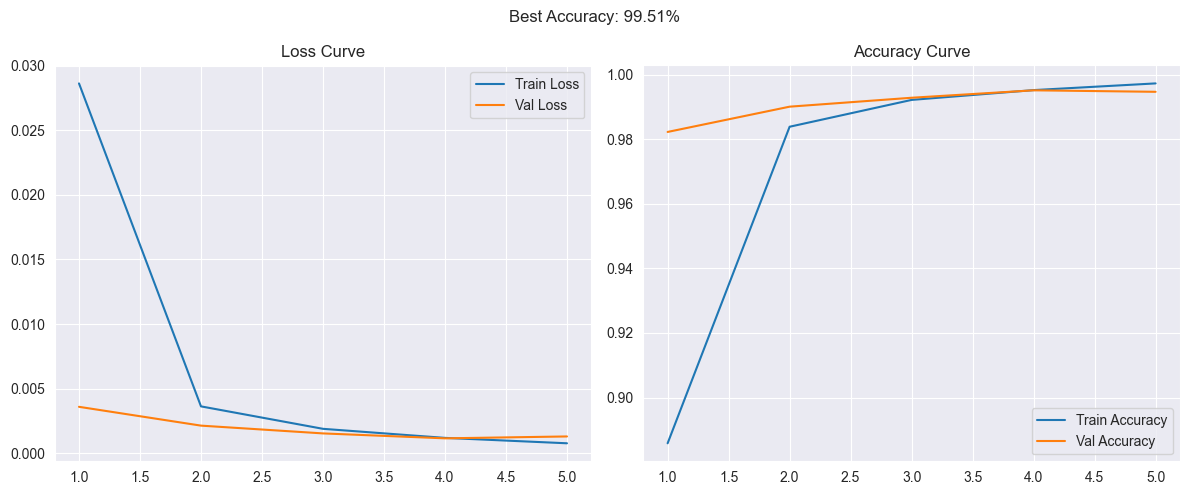

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      1.00      1.00       126
                                 Apple___Black_rot       1.00      1.00      1.00       125
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       1.00      1.00      1.00       329
                               Blueberry___healthy       0.99      0.99      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.97      0.94       103
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       239
               Corn_(maize)___Northern_Leaf_Blight     

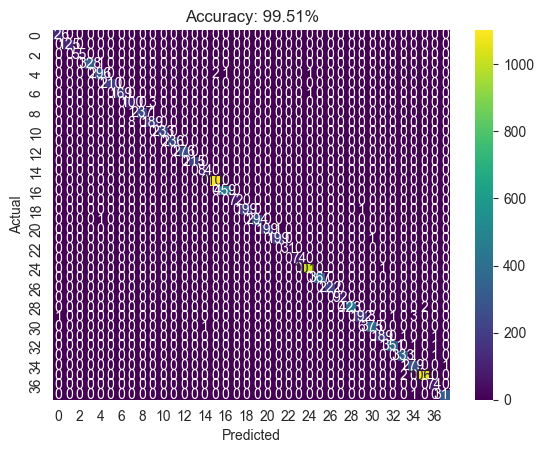

Predicted class: Apple___healthy


In [6]:
train_path = "/content/dataset/dataset/train"
val_path = "/content/dataset/dataset/val"

plant_model = PlantVillageClassifier(train_path, val_path)
plant_model.train()
plant_model.evaluate()

prediction = plant_model.predict("/content/dataset/dataset/val/Apple___healthy/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL 7669.JPG")
print("Predicted class:", prediction)

plant_model.save_model()

In [7]:
prediction = plant_model.predict("/content/dataset/dataset/val/Cherry_(including_sour)___Powdery_mildew/00e0a4ab-ecbd-4560-a71c-b19d86bb087c___FREC_Pwd.M 4917.JPG")
print("Predicted class:", prediction)

Predicted class: Cherry_(including_sour)___Powdery_mildew
